# Demo of the GMM in ischemic stroke 

In [7]:
# Import libraries
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from brukerapi.dataset import Dataset
import scipy.io
from scipy.stats import norm
import pyvista as pv

In [2]:
# Read image
data_path = '/Users/kamil/Documents/my_softwares/gmm_stroke/data/rat_model_1/6/pdata/1/2dseq/'
dataset = Dataset(data_path)
img = dataset.data.squeeze() # [x, y, z, b]
img = np.rot90(np.transpose(img, (1, 0, 2, 3)), 2)

# Read mask
brain_mask = scipy.io.loadmat('/Users/kamil/Documents/my_softwares/gmm_stroke/data/brain_mask.mat')['brain_mask']

# Read b-values
dataset.add_parameter_file('method')
bvals = dataset['PVM_DwEffBval'].value

In [3]:
# Extract brain tissue
brain_mask_4d = brain_mask[..., np.newaxis] # [x, y, z, 1]
diff_img = img * brain_mask_4d

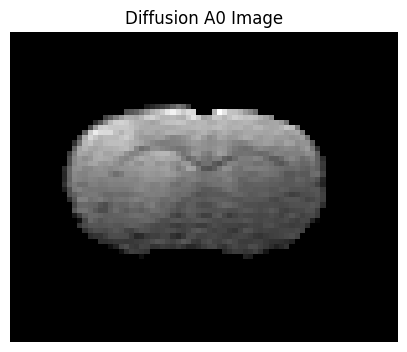

In [4]:
# Show diffusion image
plt.figure(figsize = (5, 5))
plt.imshow(diff_img[:, :, 22, 0], 
           cmap = 'gray')
plt.title(f'Diffusion A0 Image')
plt.axis('off')
plt.show();

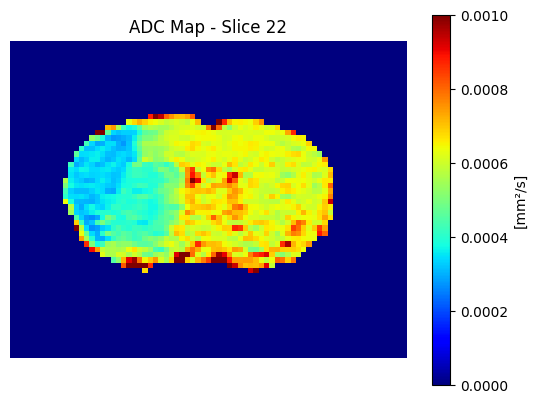

In [5]:
def compute_adc(diffImg, bvals, brain_mask):

    mask_bool = brain_mask.astype(bool)

    shape = diffImg.shape
    n_vox = np.prod(shape[:3])
    n_b = shape[3]

    data_2d = diffImg.reshape(n_vox, n_b)
    log_data = np.zeros_like(data_2d, dtype=np.float32)
    
    data_2d[data_2d <= 0] = np.nan
    log_data = np.log(data_2d)

    # Line fitting S = S0 * exp(-b * ADC) => log(S) = log(S0) - b*ADC
    ADC_map_flat = np.zeros(n_vox, dtype=np.float32)

    for idx in range(n_vox):
        if not mask_bool.reshape(-1)[idx]:
            continue
        y = log_data[idx, :]
        if np.any(np.isnan(y)):
            continue
        p = np.polyfit(bvals, y, 1)
        slope = p[0] 
        ADC_map_flat[idx] = -slope  # ADC = -slope

    ADC_map = ADC_map_flat.reshape(shape[:3])
    ADC_map[~mask_bool] = 0

    return ADC_map




ADC_map = compute_adc(diff_img, bvals, brain_mask)

plt.imshow(ADC_map[:, :, 22], cmap='jet', vmin=0, vmax=0.001)
plt.colorbar(label='[mm²/s]')
plt.title("ADC Map - Slice 22")
plt.axis('off')
plt.show();

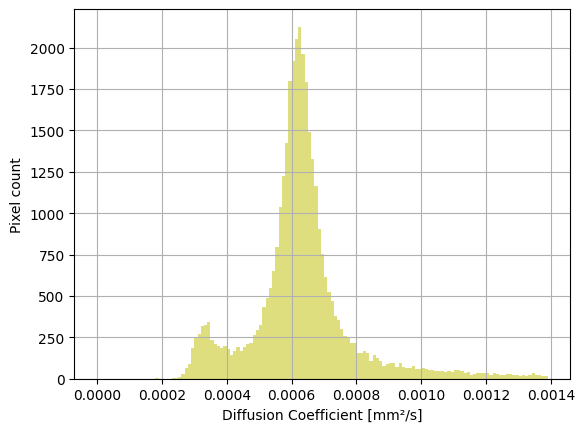

In [6]:
# Create ADC histogram
adc_vals = ADC_map[(ADC_map >= 0.00001) & (ADC_map <= 0.0014)]
plt.hist(adc_vals,
         bins = np.arange(0, 0.0014, 1e-5),
         color = 'y',
         alpha = 0.5)
plt.xlabel('Diffusion Coefficient [mm²/s]')
plt.ylabel('Pixel count')
plt.grid(True)